In [223]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchmetrics
from tqdm import tqdm
import einops


# vit package - https://github.com/lucidrains/vit-pytorch
import vit_pytorch as vit

# custom packages
import src.commons.dataset as ds
import src.commons.internal_metrics as imetrics
import src.commons.external_metrics as emetrics
import src.commons.constants as cons
from src.commons.modded_recorder import Recorder

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# send notification when training is completed
from plyer import notification

# <span style="color:green">Goal</span>

There are two available pre-trained VIT models. The goal is to write an automatized script for training both on plausible categories, and save the finetuned models + results.

## Routine 1: 
### Load datasets, split & create dataloaders, compute imbalance ratio

In [224]:
def prepare_data(category, image_size, batch_size):
    logging.info(f"Loading data from category: {category}")

    # Define transformations to be applied on each image
    transf = transforms.Compose([
        transforms.Resize((image_size, image_size)), # Resize to match TinyImagenet resolution
        transforms.Lambda(lambda T: T.long()/255) # Convert image from 0-255 uint to 0-1 long
    ])

    # Load dataset
    data = ds.MVTECViTDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), category, transforms=transf)

    # Split data into train/test/val
    train_data, test_data, val_data = torch.utils.data.random_split(data, [0.7, 0.1, 0.2])

    # Define DataLoaders for batching input
    BATCH_SIZE = 32

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    # Compute positive/negative class ratio in training data
    total_positives = 0
    total_negatives = 0
    for batch in train_dataloader:
        labels = batch["labels"]
        positive_instances = labels.sum().item()
        negative_instances = (len(labels) - positive_instances)
        total_positives += positive_instances
        total_negatives += negative_instances

    for batch in val_dataloader:
        labels = batch["labels"]
        positive_instances = labels.sum().item()
        negative_instances = (len(labels) - positive_instances)
        total_positives += positive_instances
        total_negatives += negative_instances

    class_ratio = total_negatives/total_positives
    logging.info(f"Negative/positive class ratio: {class_ratio:.2f}")

    return {
        "train_dataloader": train_dataloader,
        "test_dataloader": test_dataloader,
        "val_dataloader": val_dataloader,
        "class_ratio": class_ratio,
        "category": category,
    }

## Routine 2:
### Instantiate model, load weights, freeze parameters, add MLP head

In [225]:
def fetch_model_hyperparams(model_name):

    if model_name == "simple_vit_pretrained_0.pt":
        hyperparams = {
        "image_size": 64,
        "patch_size": 4,
        "dim": 256,
        "mlp_dim": 512,
        "depth": 2,
        "heads": 8
        }
        
    elif model_name == "simple_vit_pretrained_1.pt":
        hyperparams = {
        "image_size": 100,
        "patch_size": 5,
        "dim": 64,
        "mlp_dim": 64,
        "depth": 2,
        "heads": 8
        }

    else:
        raise ValueError("Invalid model")

    return hyperparams

def initialize_model(model_name):

    # Pretrained model hyper-parameters
    pretrained_path = ".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")

    model_hyperparams = fetch_model_hyperparams(model_name)
   
    # Load pretrained model
    model = vit.SimpleViT(
        num_classes = 200,
        **model_hyperparams
    ).to("cpu")

    loaded = torch.load(os.path.join(pretrained_path, model_name))
    logging.info(f"Loaded model, epoch:{loaded['epoch']}, loss:{loaded['loss']}")
    model.load_state_dict(loaded["model_state_dict"])

    # Freeze pretrained parameters
    for p in model.parameters():
        p.requires_grad = False

    # Discard fully-connected head, and substitute for a trainable fresh one
    model.linear_head[-1] = nn.Sequential(
        nn.Linear(model_hyperparams["dim"], model_hyperparams["mlp_dim"]),
        nn.ReLU(),
        nn.Linear(model_hyperparams["mlp_dim"], 1)
    )

    def count_trainable_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def count_frozen_parameters(model):
        return sum(p.numel() for p in model.parameters() if not p.requires_grad)

    logging.info(f"Trainable params: {count_trainable_parameters(model)}")
    logging.info(f"Frozen params: {count_frozen_parameters(model)}")

    return {
        "model": model,
        "pretrained_path": pretrained_path,
        "model_hyperparams": model_hyperparams
    }

## Routine 3
### Training (optinal unfreeze, checkpoints)

In [226]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    f1 = torchmetrics.F1Score(task="binary").to(device)

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        inputs, targets = batch["inputs"], batch["labels"]
        inputs, targets = inputs.to(device), targets.to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            logits = model(inputs)
            preds = torch.sigmoid(logits)
            pred_cats = (preds > 0.5).int()
            # acc = (pred_cats == targets).float().mean()
            acc = f1(pred_cats, targets)

        loss = loss_fn(logits, targets.float())
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    num_epochs = kwargs.get("num_epochs", 100)
    checkpoint_name = kwargs.get("checkpoint_name", "no_id")
    checkpoint_path = kwargs.get("checkpoint_path", (".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")))

    f1 = torchmetrics.F1Score(task="binary").to(device)

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        # Checkpoint best performing model in validation  
        if epoch > 2 and val_loss_hist[-2] > val_loss_hist[-1]:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(checkpoint_path, f"simple_vit_ft_{checkpoint_name}_best.pt")) 
        # Checkpoint current model
        elif epoch > 0:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss_hist[-1],
                    }, os.path.join(checkpoint_path, f"simple_vit_ft_{checkpoint_name}.pt")) 

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            inputs, targets = batch["inputs"], batch["labels"]
            inputs, targets = inputs.to(device), targets.to(device)
    
            model.zero_grad() # initialize gradients to zero
            logits = model(inputs) # forward pass

            loss = loss_fn(logits, targets.float()) # loss computation
            loss.backward() # computing gradients (backward pass)
            
            optimizer.step() # updating the parameters of the model
            # metric computation
            with torch.no_grad():
                preds = torch.sigmoid(logits)
                pred_cats = (preds > 0.5).int()
                # acc = (pred_cats == targets).float().mean()
                acc = f1(pred_cats, targets)
                
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

## Routine 4
### Define training parameters, call R3

In [227]:
def execute_training(model, train_dataloader, val_dataloader, **kwargs):
    # Define training parameters
    learning_rate = kwargs.get("learning_rate", 1e-4)
    learning_rate_unfreeze = kwargs.get("learning_rate_unfreeze", 1e-6)
    num_epochs = kwargs.get("num_epochs", 20)
    num_epochs_unfreeze = kwargs.get("num_epochs_unfreeze", 0)
    class_ratio = kwargs.get("class_ratio", 1.0)
    checkpoint_name = kwargs.get("checkpoint_name", "no_id")
    checkpoint_path = kwargs.get("checkpoint_path", (".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")))
    
    # Define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # criterion = torch.nn.BCEWithLogitsLoss()
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_ratio)) # Account for class imbalance

    # Attempt training on GPU
    if torch.cuda.is_available():
        logging.info('Selected device: cuda')
        device = torch.device('cuda')
    else:
        logging.info('Selected device: cpu')
        device = torch.device('cpu')

    # Send to device
    model = model.to(device)
    
    # Training
    train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, val_dataloader, optimizer,
                                                   loss_fn=criterion, num_epochs=num_epochs, device=device,
                                                   checkpoint_name=checkpoint_name, checkpoint_path=checkpoint_path)

    notification.notify(
    title=f"Finished training: {checkpoint_name}, epochs: {num_epochs}",
    message=f"Val acc: {val_acc[-1]:.2f}",
    timeout=60
    )

    if num_epochs_unfreeze > 0:
        logging.info(f"Unfreezing parameters...")
        
        for p in model.parameters():
            p.requires_grad = True

        optimizer_unfreeze = torch.optim.Adam(model.parameters(), lr=learning_rate_unfreeze)
        
        # Training the complete model
        temp1, temp2, temp3, temp4 = fit(model, train_dataloader, val_dataloader, optimizer_unfreeze,
                                         loss_fn=criterion, num_epochs=num_epochs_unfreeze, device=device,
                                         checkpoint_name=checkpoint_name, checkpoint_path=checkpoint_path)
        train_loss += temp1
        val_loss += temp2
        train_acc += temp3
        val_acc += temp4

        notification.notify(
        title=f"Finished training: {checkpoint_name}, epochs: {num_epochs_unfreeze}",
        message=f"Val acc: {val_acc[-1]:.2f}",
        timeout=300
        )

    return {
        "trained_model": model,
        "train_loss": train_loss,
        "train_score": train_acc,
        "val_loss": val_loss,
        "val_score": val_acc
    }

## Routine 5
### Encapsulate all previous routines, and include plotting routine for training history

In [228]:
def plot_history(train_loss, val_loss, train_acc, val_acc, unfreeze=0, **kwargs):

    category = kwargs.get("category", "no id")
    version = kwargs.get("version", -1)
    save_path = kwargs.get("save_path", (".." + cons.DIR_SEP + os.path.join("results_img_vit", "history")))
    
    with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
        plt.figure()
        plt.title("Loss")
        plt.plot(train_loss, ls="--", marker="o", lw=2.0, c="b", label="Train")
        plt.plot(val_loss, ls="--", marker="o", lw=2.0, c="r", label="Val")
        if unfreeze > 0:
            plt.axvline(unfreeze, ls="--", color="k", alpha=0.7, lw=1.5, zorder=-1)
        plt.xlabel("Epoch")
        plt.ylabel("Binary Cross-Entropy")
        plt.legend()
        plt.grid()
        plt.tight_layout()

        name = f"{category}_{version}_loss.png"
        plt.savefig(os.path.join(save_path, name), dpi=400)
        plt.close()


        ####
        plt.figure()
        plt.title("Score")
        plt.plot(train_acc, ls="--", marker="o", lw=2.0, c="b", label="Train")
        plt.plot(val_acc, ls="--", marker="o", lw=2.0, c="r", label="Val")
        if unfreeze > 0:
            plt.axvline(unfreeze, ls="--", color="k", alpha=0.7, lw=1.5, zorder=-1)
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        
        name = f"{category}_{version}_score.png"
        plt.savefig(os.path.join(save_path, name), dpi=400)
        plt.close()

In [229]:
def finetune(model_name, category, train_params):

    model_loaded = initialize_model(model_name)

    data_loaded = prepare_data(category=category, image_size=model_loaded["model_hyperparams"]["image_size"],
                               batch_size=train_params["batch_size"])
    
    train_params["class_ratio"] = data_loaded["class_ratio"]

    output = execute_training(model_loaded["model"], data_loaded["train_dataloader"], data_loaded["val_dataloader"],
                              **train_params)

    plot_history(output["train_loss"], output["val_loss"],
                 output["train_score"], output["val_score"],
                 unfreeze=train_params["num_epochs_unfreeze"],
                 category=category, version=(0 if str(0) in model_name else 1))

    return output["trained_model"]


# Test routines implemented so far

```python
categories = ["bottle", "cable", "hazelnut",
              "leather", "screw", "transistor"]
```

In [197]:
model_version = 0
model_name = f"simple_vit_pretrained_{model_version}.pt"

category = "hazelnut"

train_params = {
    "batch_size": 32,
    "checkpoint_name": f"{category}_{model_version}",
    "checkpoint_path": (".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")),
    "learning_rate": 1e-4,
    "learning_rate_unfreeze": 1e-6,
    "num_epochs": 20,
    "num_epochs_unfreeze": 0,
}

print(f"Preparing to finetune {model_name} on {category} data")

Preparing to finetune simple_vit_pretrained_0.pt on hazelnut data


In [198]:
my_model = finetune(model_name, category, train_params)

INFO:root:Loaded model, epoch:16, loss:3.3293343412990386
INFO:root:Trainable params: 132097
INFO:root:Frozen params: 1589504
INFO:root:Loading data from category: hazelnut


KeyboardInterrupt: 

## Routine 6 
### Predict on test set, extract attention masks, compute metrics, save images

In [230]:
def load_trained_model(category, version, best=True, path=None):
    # Default path is the same as default checkpoint path
    if path is None:
        path = (".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning"))

    # Instantiate model
    if version == 0:
        model_loaded = initialize_model("simple_vit_pretrained_0.pt")
    elif version == 1:
        model_loaded = initialize_model("simple_vit_pretrained_1.pt")
    else:
        raise ValueError("Invalid model")

    model = model_loaded["model"]

    # Load weights
    name = f"simple_vit_ft_{category}_{version}_best.pt" if best else f"simple_vit_ft_{category}_{version}.pt"
    finetuned_weights = torch.load(os.path.join(path, name))
    logging.info(f"Updated model with finetuned weights: {os.path.join(path, name)}")
    model.load_state_dict(finetuned_weights["model_state_dict"])

    return {
        "model": model,
        "model_hyperparams": model_loaded["model_hyperparams"]
    }   

In [279]:
def predict_with_attention(model, data_loader, **kwargs):
    device = kwargs.get("device", torch.device("cpu"))
    image_size = kwargs.get("image_size", 64)
    patch_size = kwargs.get("patch_size", 4)

    t = transforms.Resize(image_size)

    images, labels, results, attn_masks, ground_truths, raw_logits = [], [], [], [], [], []

    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:

        data, targets, ground_truth = batch["inputs"], batch["labels"], batch["ground_truth"]
        n_batch = data.shape[0]
        data, targets = data.to(device), targets.to(device)
        
        with torch.no_grad(): # no need to compute gradients
            logits, attns = model(data) # attns: (batch x layers x heads x patch x patch)
            preds = torch.sigmoid(logits)
            pred_cats = preds > 0.5

        # Compute attention mask
        attns = attns.mean(dim=2) # average over heads
        attn_prod = attns[:, 0] # recursively multiply attentions
        for i in range(1, attns.shape[1]):
            attn_prod = torch.matmul(attn_prod, attns[:, i])

        attn_vals_to_mask = attn_prod[:, -1].reshape((n_batch, image_size//patch_size, image_size//patch_size))
        attn_mask = t(attn_vals_to_mask.unsqueeze(1)) # match image size
        # Normalize masks
        for n in range(n_batch):
            attn_mask[n] = (attn_mask[n] - attn_mask[n].min())/(attn_mask[n].max() - attn_mask[n].min())

        # Resize and normalize
        ground_truth = t(ground_truth)[:, 0, ...] / 255.0

        attn_masks.append(attn_mask.squeeze())
        images.append(data)
        labels.append(targets)
        results.append(pred_cats)
        ground_truths.append(ground_truth)
        raw_logits.append(logits)

    images = torch.concat(tuple([einops.rearrange(image, "b c h w -> b h w c")
                                 for image in images]), dim=0)
    labels = torch.concat(tuple([label for label in labels]))
    results = torch.concat(tuple([result for result in results]))
    attn_masks = torch.concat(tuple([attn for attn in attn_masks]))
    ground_truths = torch.concat(tuple([gt for gt in ground_truths]))
    raw_logits = torch.concat(tuple([logit for logit in raw_logits]))

    return images.cpu().numpy(), labels.cpu().numpy(), results.cpu().numpy(), \
           attn_masks.cpu().numpy(), ground_truths.cpu().numpy(), raw_logits.cpu().numpy()

In [323]:
def compute_metrics(images, labels, results, attn_masks, ground_truths, logits,
                    threshold=0.5):


    ground_truths = ground_truths.astype(np.int32)

    # Compute PRO values
    PRO_values = []
    for mask, gt in zip(attn_masks, ground_truths):
        PRO_values.append(imetrics.get_pro(gt, mask, threshold))
    PRO_values = np.array(PRO_values)

    PRO_results = {
        "scores": PRO_values,
        "mean": PRO_values.mean(),
        "std": PRO_values.std(),
        "threshold": threshold
    }

    f1 = torchmetrics.F1Score(task="binary")  
    f1_score = f1(torch.tensor(results), torch.tensor(labels))

    # Compute threhsold-independent metrics
    roc = torchmetrics.ROC(task="binary")
    fpr, tpr, thresholds = roc(torch.tensor(logits), torch.tensor(labels))
    auroc = torchmetrics.AUROC(task="binary")
    area = auroc(torch.tensor(logits), torch.tensor(labels).int())
    threshold_ind_metrics = {
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "area": area
    }


    seg_metrics = imetrics.fpr_pro_iou_curves(ground_truths, attn_masks)

    return PRO_results, f1_score, threshold_ind_metrics, seg_metrics


In [289]:
%matplotlib inline
# Refs: https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook

def plot_attentions(images, labels, pred_cats, masks, **kwargs):

    image_size = kwargs.get("image_size", 64)
    patch_size = kwargs.get("patch_size", 4)
    ground_truths = kwargs.get("ground_truths", None)
    pro_results = kwargs.get("pro_results", None)
    category = kwargs.get("category", "no id")
    version = kwargs.get("version", None)
    save_path = kwargs.get("save_path", (".." + cons.DIR_SEP + os.path.join("results_img_vit", category)))
    logging.info(f"Saving images to {save_path}")
    n_images = images.shape[0]


    with plt.rc_context(rc={'font.size': 9}):
        for i in range(n_images):
            fig, ax = plt.subplots(figsize=(4, 4))

            # Plot correct predictions for anomalous objects
            img = images[i]
            img_label = labels[i]
            pred_label = pred_cats[i].astype(np.int32)

            mask = masks[i]
            
            ax.imshow(img, zorder=0)
            ax.imshow(mask, alpha=mask, cmap="viridis", zorder=2)

            # Plot ground truth mask if provided when anomalous
            if ground_truths is not None and img_label > 0:
                gt = ground_truths[i]
                ax.imshow(gt, alpha=0.6*gt, cmap="Greys_r", zorder=1)
                if pro_results is not None:
                    pro = pro_results["scores"][i]
                    ax.text(0, 0.9, f"PRO: {pro:.2f}", color="k",
                            backgroundcolor="w", transform=ax.transAxes)
        
            if pred_label == img_label:
                ax.set_title(f"Pred: {pred_label} / Truth: {img_label}", color="green")
            else:
                ax.set_title(f"Pred: {pred_label} / Truth: {img_label}", color="red")

            ax.set_axis_off()
            fig.tight_layout()
            name = f"v{version}_{i}.png" if version is not None else f"{i}.png"
            fig.savefig(os.path.join(save_path, name), dpi=400)
            plt.close()


        return 

In [324]:
def eval_performance(category, version, batch_size=8, best=True, path=None, plot=True):

    # Prepare model
    model_loaded = load_trained_model(category, version, best, path)
    model = Recorder(model_loaded["model"]) # set up model to return attention weights in forward pass
    image_size, patch_size = model_loaded["model_hyperparams"]["image_size"], model_loaded["model_hyperparams"]["patch_size"]

    # Get data
    data_loaded = prepare_data(category=category, image_size=image_size,
                               batch_size=batch_size)


    # Extract results
    images, labels, pred_cats, masks, gts, logits = predict_with_attention(model, data_loaded["test_dataloader"],
                                                                           image_size=image_size, patch_size=patch_size)


    model = model.eject() # remove hooks from forward pass

    # Compute metrics

    metrics = compute_metrics(images, labels, pred_cats, masks, gts, logits)
    logging.info(f"Computed metrics for {category}, v{version}")
    
    ############### quick check #######################
    # index = np.where(labels.detach().numpy() > 0)[0][0]

    # plt.figure()
    # img = images[index]

    # plt.title(f"label {labels[index]}")
    # plt.imshow(img)
    # plt.imshow(attns[index], alpha=attns[index])
    # plt.imshow(gts[index], alpha=0.3*gts[index], cmap="Greys_r")

    ############### *********** #######################

    # Produce attention plots
    if plot:
        plot_attentions(images, labels, pred_cats, masks,
                        ground_truths=gts, pro_results=metrics[0],
                        category=category, version=version,
                        image_size=image_size, patch_size=patch_size)

    return metrics

### Test evaluation routines

In [210]:
eval_performance("hazelnut", version=0)

INFO:root:Loaded model, epoch:16, loss:3.3293343412990386
INFO:root:Trainable params: 132097
INFO:root:Frozen params: 1589504
INFO:root:Updated model with finetuned weights: ..\results\vit_finetuning\simple_vit_ft_hazelnut_0_best.pt
INFO:root:Loading data from category: hazelnut


KeyboardInterrupt: 

# Everything is working, now let's apply it systematically


```python
categories = ["bottle", "cable", "hazelnut",
              "leather", "screw", "transistor"]
```

Training

In [235]:
# model_version = 0
# model_name = f"simple_vit_pretrained_{model_version}.pt"
# category = "transistor"
from IPython.display import clear_output

for category in ["transistor", "tile", "wood"]:
    for model_version in [0, 1]:

        model_name = f"simple_vit_pretrained_{model_version}.pt"

        train_params = {
            "batch_size": 32,
            "checkpoint_name": f"{category}_{model_version}",
            "checkpoint_path": (".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")),
            "learning_rate": 5e-4,
            "learning_rate_unfreeze": 1e-6,
            "num_epochs": 30,
            "num_epochs_unfreeze": 30,
        }

        print(f"Preparing to finetune {model_name} on {category} data")

        my_model = finetune(model_name, category, train_params)

        eval_performance(category, version=model_version)

        clear_output()

In [ ]:
for category in ["transistor", "tile", "wood"]:
    for model_version in [0, 1]:

        model_name = f"simple_vit_pretrained_{model_version}.pt"

        train_params = {
            "batch_size": 32,
            "checkpoint_name": f"{category}_{model_version}",
            "checkpoint_path": (".." + cons.DIR_SEP + os.path.join("results", "vit_finetuning")),
            "learning_rate": 5e-4,
            "learning_rate_unfreeze": 1e-6,
            "num_epochs": 30,
            "num_epochs_unfreeze": 30,
        }

        print(f"Preparing to finetune {model_name} on {category} data")

        my_model = finetune(model_name, category, train_params)

        eval_performance(category, version=model_version)

        clear_output()

Scores

In [326]:
# Register scores

my_results = {}

for category in ["bottle", "cable", "hazelnut", "leather",
                 "screw", "transistor", "tile", "wood"]:
    for model_version in [0, 1]:

        model_name = f"simple_vit_pretrained_{model_version}.pt"

        metrics = eval_performance(category, version=model_version, plot=False)

        my_results[f"{category}_{model_version}"] = metrics

        notification.notify(
        title=f"Finished eval",
        message=f"{category} {model_version}",
        timeout=300
        )

        clear_output()

INFO:root:Loaded model, epoch:16, loss:3.3293343412990386
INFO:root:Trainable params: 132097
INFO:root:Frozen params: 1589504
INFO:root:Updated model with finetuned weights: ..\results\vit_finetuning\simple_vit_ft_bottle_0_best.pt
INFO:root:Loading data from category: bottle


In [292]:
path = ".." + cons.DIR_SEP + "results"
name = "f1_scores.txt"

with open(os.path.join(path, name), "w") as f:
    f.write(f"{'Model Name':15} \t f1 Score \n \n")
    for model, metrics in my_results.items():
        f1 = metrics[1].float()
        f.write(f"{model:15} \t {f1:5.4f} \n")

In [293]:
path = ".." + cons.DIR_SEP + "results"
name = "PRO_scores.txt"

with open(os.path.join(path, name), "w") as f:
    f.write(f"{'Model Name':15} \t {'PRO Mean':8} \t PRO Std \n \n")
    for model, metrics in my_results.items():
        PRO_mean, PRO_std = metrics[0]["mean"], metrics[0]["std"]
        f.write(f"{model:15} \t {PRO_mean:8.4f} \t {PRO_std:8.4f} \n")

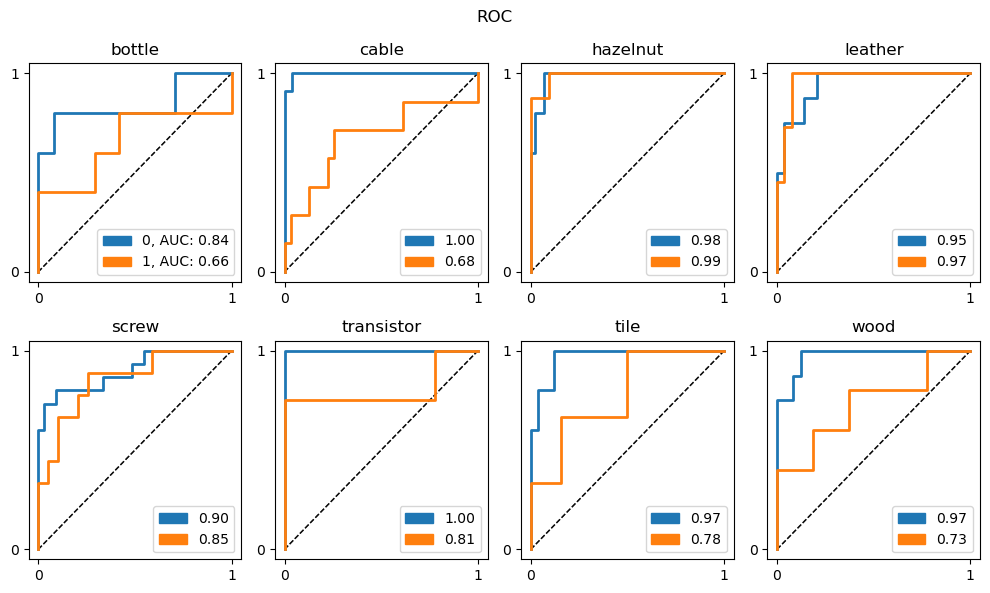

In [322]:
import matplotlib.patches as mpatches

plt.rcParams.update({
    "font.family": "Helvetica"
})

fig, ax = plt.subplots(2, 4, figsize=(10, 6))

n_col = 0
n_row = 0


for i, category in enumerate(["bottle", "cable", "hazelnut", "leather",
                              "screw", "transistor", "tile", "wood"]):
    
    n_row = 0 if i < 4 else 1
    n_col = i % 4

    ca = ax[n_row, n_col]    

    for model_version in [0, 1]:


        key = f"{category}_{model_version}"
        metrics = my_results[key]
        threshold_ind_metrics = metrics[2]
        fpr =  threshold_ind_metrics["fpr"]
        tpr =  threshold_ind_metrics["tpr"]
        thresholds =  threshold_ind_metrics["thresholds"]

        area =  threshold_ind_metrics["area"]

        with plt.rc_context(rc={'font.size': 9}):

            if model_version == 0:
                blue_label = f"0, AUC: {area:.2f}" if i==0 else f"{area:.2f}"
            else:
                orange_label = f"1, AUC: {area:.2f}" if i==0 else f"{area:.2f}"

            ca.plot(fpr, tpr, ls="-", lw=2.0)
            ca.plot([0, 1], [0, 1], c="k", ls="--", lw=1.0, alpha=0.8, zorder=-1)
            
            # plt.gca().text(0.8, 0.05, f"AUC: {area:.3f}", color="k",
            #             backgroundcolor="w", transform=plt.gca().transAxes)

    blue_patch = mpatches.Patch(color='C0', label=blue_label)
    orange_patch = mpatches.Patch(color='C1', label=orange_label)

    ca.set_title(f"{category}")
    ca.set_xticks([0, 1])
    ca.set_xticklabels([0, 1])
    ca.set_yticks([0, 1])
    ca.set_yticklabels([0, 1])

    ca.legend(loc="lower right", handles=[blue_patch, orange_patch])

fig.suptitle("ROC", fontsize=12)
fig.tight_layout()

        